<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/conv_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import display

In [1]:
#!pip install wandb

In [6]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from tqdm import tqdm_notebook

In [2]:
%matplotlib inline

In [3]:
cifar_means = (0.49139968, 0.48215827, 0.44653124)
cifar_stds = (0.24703233, 0.24348505, 0.26158768)

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(cifar_means, cifar_stds)])

In [8]:
BATCH_TRAIN = 10
BATCH_TEST = 100
WRKRS = 2
TOWHERE = './data'
SEED = 42
EPOCHS = 3
LR = 1e-4

In [9]:
trainset = datasets.CIFAR10(root = TOWHERE, train=True, download=True, transform = transform)
testset = datasets.CIFAR10(root = TOWHERE, train=False, download=True, transform = transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_TRAIN, num_workers = WRKRS, pin_memory = True, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = BATCH_TEST, num_workers = WRKRS, pin_memory = True, shuffle = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 50957115.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [11]:
print('Train:', train_loader.dataset.data.shape)
print('Test:', test_loader.dataset.data.shape)

Train: (50000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [12]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEDD'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.determetistic = True

seed_all(SEED)

In [13]:
class MyCIFAR(nn.Module):
  def __init__(self):
    super(MyCIFAR, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.flatten = nn.Flatten()
    
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def convolute(self, conv, x):
    convd = conv(x)
    activated = F.relu(convd)
    pooled = self.pool(activated)
    return pooled

  def fcs(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x


  def forward(self, x):
    x = self.convolute(self.conv1, x)
    x = self.convolute(self.conv2, x)
    x = self.flatten(x)
    x = self.fcs(x)
    return x


In [14]:
net = MyCIFAR()
optimizer = optim.Adam(net.parameters(), lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [15]:
curloss = 0.0
for epoch in range(EPOCHS):
  for i, batch in enumerate(tqdm_notebook(train_loader)):
    optimizer.zero_grad()
    X, y = batch
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    curloss += loss.item()

    if not (i % int(train_loader.dataset.data.shape[0] / BATCH_TRAIN / 10)):
      print(f'Epoch: {epoch+1}, loss: {round(curloss, 3)}')
      curloss = 0.0

<ipython-input-15-c34070defe64>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 1, loss: 2.294
Epoch: 1, loss: 1105.874
Epoch: 1, loss: 1012.948
Epoch: 1, loss: 973.95
Epoch: 1, loss: 944.212
Epoch: 1, loss: 913.8
Epoch: 1, loss: 900.928
Epoch: 1, loss: 887.611
Epoch: 1, loss: 887.201
Epoch: 1, loss: 870.061


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2, loss: 852.987
Epoch: 2, loss: 841.358
Epoch: 2, loss: 829.557
Epoch: 2, loss: 831.65
Epoch: 2, loss: 832.549
Epoch: 2, loss: 817.166
Epoch: 2, loss: 820.491
Epoch: 2, loss: 812.834
Epoch: 2, loss: 824.55
Epoch: 2, loss: 803.855


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 3, loss: 809.88
Epoch: 3, loss: 792.081
Epoch: 3, loss: 793.62
Epoch: 3, loss: 783.274
Epoch: 3, loss: 772.94
Epoch: 3, loss: 788.113
Epoch: 3, loss: 772.775
Epoch: 3, loss: 789.04
Epoch: 3, loss: 773.524
Epoch: 3, loss: 760.552


In [16]:
class_correct = [0]*10
class_total = [0]*10

In [17]:
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    y_pred = net(images)
    _, predicted = torch.max(y_pred,1)
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


for i in range(10):
  print(f'Accuracy: {classes[i]}: {100 * class_correct[i] / class_total[i]}%')

Accuracy: plane: 62.1%
Accuracy: car: 56.1%
Accuracy: bird: 44.2%
Accuracy: cat: 23.4%
Accuracy: deer: 37.5%
Accuracy: dog: 45.2%
Accuracy: frog: 71.9%
Accuracy: horse: 61.1%
Accuracy: ship: 0.0%
Accuracy: truck: 66.5%


Conditions:

> Batchsize:4

> Start loss: ~900

> End loss: ~400


>>Accuracy: plane: 51.6%

>>Accuracy: car: 63.7%

>>Accuracy: bird: 34.6%

>>Accuracy: cat: 53.8%

>>Accuracy: deer: 42.4%

>>Accuracy: dog: 0.0%

>>Accuracy: frog: 74.2%

>>Accuracy: horse: 66.9%

>>Accuracy: ship: 69.3%

>>Accuracy: truck: 55.8%

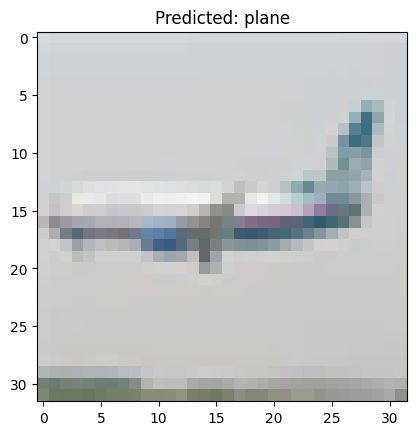

In [25]:
def visualize_result(idx):
    img = test_loader.dataset.data[idx]
    plt.imshow(img)
    
    image = transform(img)  
    y_pred = net(image.view(1, 3, 32, 32))
    _, predicted = torch.max(y_pred, 1)
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(np.random.randint(low=0, high=10000))